# Purpose
- Purpose of this notebook is to build baseline models;
    - Baseline 1: Predict last observation
    - Baseline 2: Predict Moving average of last 7 days
    - Baseline 3: Predict sale for the same day in the previous week
    - Baseline 4: Predict the average of the last 4 weeks for the same day

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from tqdm import tqdm
from IPython.display import display
from sklearn.metrics import mean_absolute_error

from src import data_manipulate, plot

In [2]:
# import csv data into pandas dataframe
df_data = pd.read_csv('data/preprocessed/data_preprocessed.csv')
df_data

,family,store_nbr,date,sales,onpromotion
0,AUTOMOTIVE,1,2013-01-01,0.0,0
1,AUTOMOTIVE,1,2013-01-02,2.0,0
2,AUTOMOTIVE,1,2013-01-03,3.0,0
3,AUTOMOTIVE,1,2013-01-04,3.0,0
4,AUTOMOTIVE,1,2013-01-05,5.0,0
...,...,...,...,...,...
3008011,SEAFOOD,54,2017-08-11,0.0,0
3008012,SEAFOOD,54,2017-08-12,1.0,1
3008013,SEAFOOD,54,2017-08-13,2.0,0
3008014,SEAFOOD,54,2017-08-14,0.0,0


# Convert data to multi-output format

- **7 day prediction horizon with 0 lead time**

In [3]:
multi_steps = data_manipulate.make_multistep_target(df_data, steps=7, lead_time=0)

df_data = multi_steps.merge(df_data, left_index=True, right_index=True).reset_index(drop=True)
df_data

,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7,family,store_nbr,date,sales,onpromotion
0,0.0,2.0,3.0,3.0,5.0,2.0,0.0,AUTOMOTIVE,1,2013-01-01,0.0,0
1,2.0,3.0,3.0,5.0,2.0,0.0,2.0,AUTOMOTIVE,1,2013-01-02,2.0,0
2,3.0,3.0,5.0,2.0,0.0,2.0,2.0,AUTOMOTIVE,1,2013-01-03,3.0,0
3,3.0,5.0,2.0,0.0,2.0,2.0,2.0,AUTOMOTIVE,1,2013-01-04,3.0,0
4,5.0,2.0,0.0,2.0,2.0,2.0,3.0,AUTOMOTIVE,1,2013-01-05,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2997319,3.0,0.0,0.0,12.0,4.0,2.0,0.0,SEAFOOD,54,2017-08-05,3.0,1
2997320,0.0,0.0,12.0,4.0,2.0,0.0,1.0,SEAFOOD,54,2017-08-06,0.0,0
2997321,0.0,12.0,4.0,2.0,0.0,1.0,2.0,SEAFOOD,54,2017-08-07,0.0,0
2997322,12.0,4.0,2.0,0.0,1.0,2.0,0.0,SEAFOOD,54,2017-08-08,12.0,0


# Add features

- **Add lag features to the data**


In [4]:
# add sales lag features
lag_features = data_manipulate.add_lag_features(df_data, column='sales', lags=28, lead_time=1)
df_data = df_data.merge(lag_features, left_index=True, right_index=True)

# drop sales column
df_data.drop(columns=['sales'], inplace=True)

In [5]:
df_data.head()

,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7,family,store_nbr,date,...,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28
0,0.0,2.0,3.0,3.0,5.0,2.0,0.0,AUTOMOTIVE,1,2013-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,3.0,3.0,5.0,2.0,0.0,2.0,AUTOMOTIVE,1,2013-01-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,3.0,5.0,2.0,0.0,2.0,2.0,AUTOMOTIVE,1,2013-01-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,5.0,2.0,0.0,2.0,2.0,2.0,AUTOMOTIVE,1,2013-01-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,2.0,0.0,2.0,2.0,2.0,3.0,AUTOMOTIVE,1,2013-01-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Train Test split

In [6]:
X_train, y_train, X_test, y_test = data_manipulate.train_test_split_multi_step(df_data, cutoff_date='2017-01-01')

In [7]:
print(f'{X_train.shape=}')
display(X_train.head())
print(f'{y_train.shape=}')
display(y_train.head())
print(f'{X_test.shape=}')
display(X_test.head())
print(f'{y_test.shape=}')
display(y_test.head())

X_train.shape=(2603502, 32)


,family,store_nbr,date,onpromotion,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,...,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28
0,AUTOMOTIVE,1,2013-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUTOMOTIVE,1,2013-01-02,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUTOMOTIVE,1,2013-01-03,0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUTOMOTIVE,1,2013-01-04,0,3.0,2.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUTOMOTIVE,1,2013-01-05,0,3.0,3.0,2.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


y_train.shape=(2603502, 7)


,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
0,0.0,2.0,3.0,3.0,5.0,2.0,0.0
1,2.0,3.0,3.0,5.0,2.0,0.0,2.0
2,3.0,3.0,5.0,2.0,0.0,2.0,2.0
3,3.0,5.0,2.0,0.0,2.0,2.0,2.0
4,5.0,2.0,0.0,2.0,2.0,2.0,3.0


X_test.shape=(393822, 32)


,family,store_nbr,date,onpromotion,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,...,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28
1461,AUTOMOTIVE,1,2017-01-01,0,2.0,4.0,3.0,12.0,5.0,0.0,...,4.0,3.0,0.0,3.0,6.0,5.0,1.0,0.0,4.0,1.0
1462,AUTOMOTIVE,1,2017-01-02,0,0.0,2.0,4.0,3.0,12.0,5.0,...,0.0,4.0,3.0,0.0,3.0,6.0,5.0,1.0,0.0,4.0
1463,AUTOMOTIVE,1,2017-01-03,0,5.0,0.0,2.0,4.0,3.0,12.0,...,5.0,0.0,4.0,3.0,0.0,3.0,6.0,5.0,1.0,0.0
1464,AUTOMOTIVE,1,2017-01-04,0,4.0,5.0,0.0,2.0,4.0,3.0,...,1.0,5.0,0.0,4.0,3.0,0.0,3.0,6.0,5.0,1.0
1465,AUTOMOTIVE,1,2017-01-05,0,1.0,4.0,5.0,0.0,2.0,4.0,...,6.0,1.0,5.0,0.0,4.0,3.0,0.0,3.0,6.0,5.0


y_test.shape=(393822, 7)


,multi_step_1,multi_step_2,multi_step_3,multi_step_4,multi_step_5,multi_step_6,multi_step_7
1461,0.0,5.0,4.0,1.0,2.0,2.0,5.0
1462,5.0,4.0,1.0,2.0,2.0,5.0,0.0
1463,4.0,1.0,2.0,2.0,5.0,0.0,2.0
1464,1.0,2.0,2.0,5.0,0.0,2.0,3.0
1465,2.0,2.0,5.0,0.0,2.0,3.0,10.0


# Baseline 1: Predict last observation

In [8]:
# LOCF baseline model
class BaselineModelLOCF:
    '''Prediction = last observed value'''
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass
        
    def predict(self, X: pd.DataFrame, y: pd.DataFrame) -> pd.DataFrame:

        # merge X and y on index
        df = X.merge(y, left_index=True, right_index=True)

        # select all columns that has multi_step in it
        multi_step_columns = [col for col in df.columns if 'multi_step' in col]

        for i in range(len(multi_step_columns)):
            df[f'multi_step_{i+1}'] = df['sales_lag_1']

        predictions = df[multi_step_columns]

        return np.array(predictions)

In [10]:
model = BaselineModelLOCF()
predictions = model.predict(X_test, y_test)

In [11]:
test_mae = mean_absolute_error(y_test, predictions)
print(f'{test_mae=:.4f}')

test_mae=151.3518


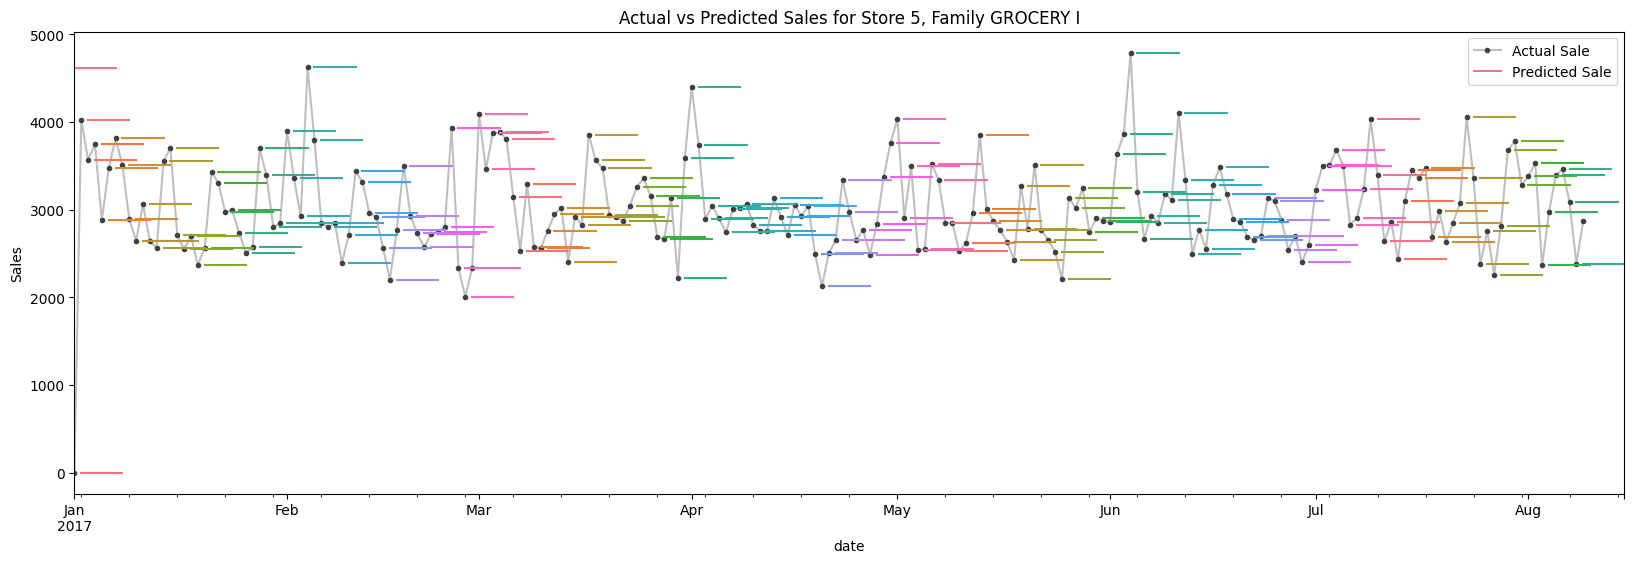

In [19]:
warnings.filterwarnings('ignore')

# join predictions to X_test store_nbr and family
predictions = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)

prediction_test_set = X_test[['store_nbr', 'family', 'date']].merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='left')
prediction_test_set.rename(columns={0: 'multi_step_1', 1: 'multi_step_2', 2: 'multi_step_3', 3: 'multi_step_4', 4: 'multi_step_5', 5: 'multi_step_6', 6: 'multi_step_7'}, inplace=True)

# join y_test to X_test store_nbr and family
actual_test_set = X_test[['store_nbr', 'family', 'date']].merge(y_test, left_index=True, right_index=True, how='left')

plot.plot_predictions(prediction_test_set, actual_test_set, 5, 'GROCERY I')

# Baseline 2: Predict Moving average of last 7 days

In [20]:
# Moving Average model
class BaselineModelMovingAverage:
    '''Prediction = moving average of the last n days'''
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass
        
    def predict(self, X: pd.DataFrame, y: pd.DataFrame, moving_average_window: int) -> np.array:
        
        # merge X and y on index
        df = X.merge(y, left_index=True, right_index=True)

        # select all columns that has multi_step in it
        multi_step_columns = [col for col in df.columns if 'multi_step' in col]

        # select all columns that has sales_lag in it up to the moving average window
        moving_average_columns = [col for col in df.columns if 'sales_lag' in col][:moving_average_window]

        for i in range(len(multi_step_columns)):
            df[f'multi_step_{i+1}'] = np.mean(df[moving_average_columns], axis=1)

        predictions = df[multi_step_columns]

        return np.array(predictions)

In [21]:
model = BaselineModelMovingAverage()
predictions = model.predict(X_test, y_test, moving_average_window=7)

In [22]:
test_mae = mean_absolute_error(y_test, predictions)
print(f'{test_mae=:.4f}')

test_mae=118.5240


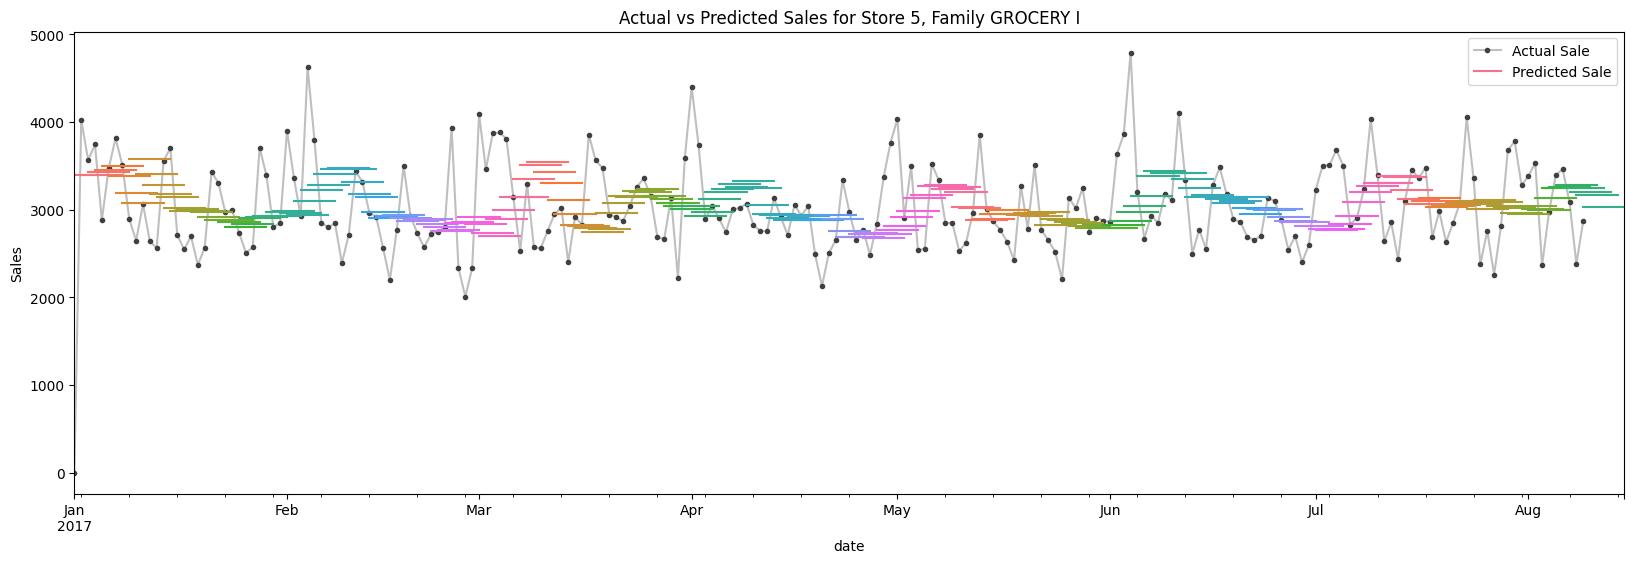

In [23]:
warnings.filterwarnings('ignore')

# join predictions to X_test store_nbr and family
predictions = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)

prediction_test_set = X_test[['store_nbr', 'family', 'date']].merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='left')
prediction_test_set.rename(columns={0: 'multi_step_1', 1: 'multi_step_2', 2: 'multi_step_3', 3: 'multi_step_4', 4: 'multi_step_5', 5: 'multi_step_6', 6: 'multi_step_7'}, inplace=True)

# join y_test to X_test store_nbr and family
actual_test_set = X_test[['store_nbr', 'family', 'date']].merge(y_test, left_index=True, right_index=True, how='left')

plot.plot_predictions(prediction_test_set, actual_test_set, 5, 'GROCERY I')

# Baseline 3: Predict sale for the same day in the previous week


In [24]:
class BaselineModelPreviousWeek:
    '''Prediction = actual demand observed at t-7 days'''
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass
        
    def predict(self, X: pd.DataFrame, y: pd.DataFrame) -> pd.DataFrame:

        # merge X and y on index
        df = X.merge(y, left_index=True, right_index=True)

        # select all columns that has multi_step in it
        multi_step_columns = [col for col in df.columns if 'multi_step' in col]

        for i in range(len(multi_step_columns)):
            df[f'multi_step_{i+1}'] = df[f'sales_lag_{7-i}']

        predictions = df[multi_step_columns]

        return np.array(predictions)

In [25]:
model = BaselineModelPreviousWeek()
predictions = model.predict(X_test, y_test)

In [26]:
test_mae = mean_absolute_error(y_test, predictions)
print(f'{test_mae=:.4f}')

test_mae=96.0924


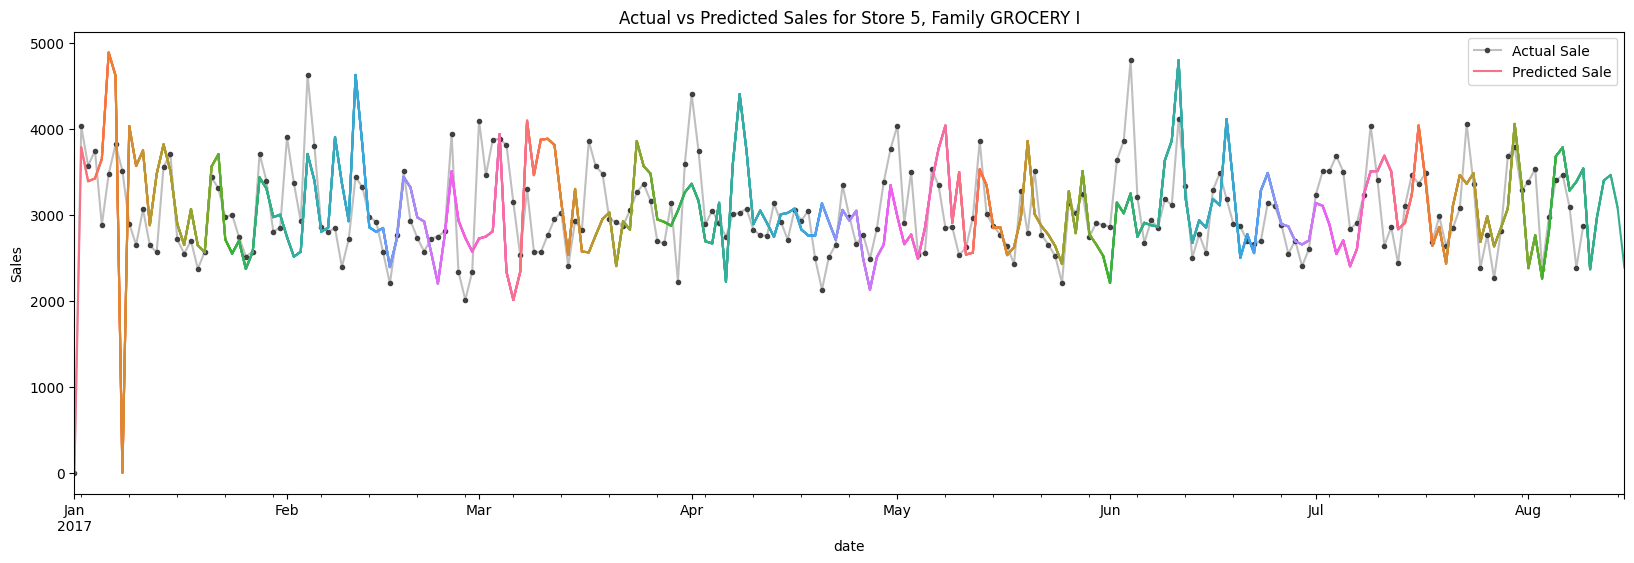

In [27]:
warnings.filterwarnings('ignore')

# join predictions to X_test store_nbr and family
predictions = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)

prediction_test_set = X_test[['store_nbr', 'family', 'date']].merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='left')
prediction_test_set.rename(columns={0: 'multi_step_1', 1: 'multi_step_2', 2: 'multi_step_3', 3: 'multi_step_4', 4: 'multi_step_5', 5: 'multi_step_6', 6: 'multi_step_7'}, inplace=True)

# join y_test to X_test store_nbr and family
actual_test_set = X_test[['store_nbr', 'family', 'date']].merge(y_test, left_index=True, right_index=True, how='left')

plot.plot_predictions(prediction_test_set, actual_test_set, 5, 'GROCERY I')

# Baseline 4: Predict the average of the last 4 weeks for the same day


In [28]:
class BaselineModelPrevious4Weeks:
    '''Prediction = actual demand observed at t-7 days, t-14 days, t-21 days, t-28'''
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass
        
    def predict(self, X: pd.DataFrame, y: pd.DataFrame) -> pd.DataFrame:

        # merge X and y on index
        df = X.merge(y, left_index=True, right_index=True)

        # select all columns that has multi_step in it
        multi_step_columns = [col for col in df.columns if 'multi_step' in col]

        for i in range(len(multi_step_columns)):
            df[f'multi_step_{i+1}'] = (df[f'sales_lag_{7-i}'] + df[f'sales_lag_{14-i}'] + df[f'sales_lag_{21-i}'] + df[f'sales_lag_{28-i}']) / 4

        predictions = df[multi_step_columns]

        return np.array(predictions)

In [29]:
model = BaselineModelPrevious4Weeks()
predictions = model.predict(X_test, y_test)

In [30]:
test_mae = mean_absolute_error(y_test, predictions)
print(f'{test_mae=:.4f}')

test_mae=84.1223


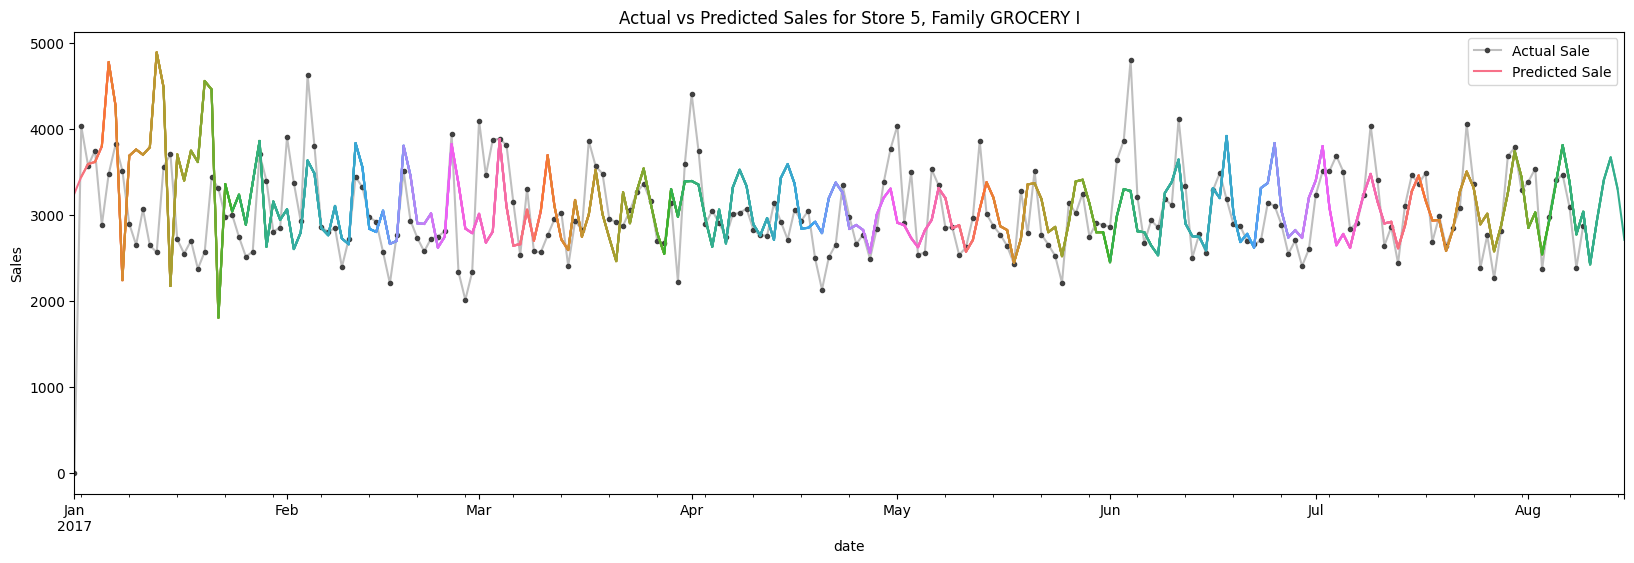

In [31]:
warnings.filterwarnings('ignore')

# join predictions to X_test store_nbr and family
predictions = pd.DataFrame(predictions, columns=y_test.columns, index=y_test.index)

prediction_test_set = X_test[['store_nbr', 'family', 'date']].merge(pd.DataFrame(predictions), left_index=True, right_index=True, how='left')
prediction_test_set.rename(columns={0: 'multi_step_1', 1: 'multi_step_2', 2: 'multi_step_3', 3: 'multi_step_4', 4: 'multi_step_5', 5: 'multi_step_6', 6: 'multi_step_7'}, inplace=True)

# join y_test to X_test store_nbr and family
actual_test_set = X_test[['store_nbr', 'family', 'date']].merge(y_test, left_index=True, right_index=True, how='left')

plot.plot_predictions(prediction_test_set, actual_test_set, 5, 'GROCERY I')

# Summary of baseline models
- **Baseline 1**: Predict last observation
    - MAE = 151.3518
- **Baseline 2**: Predict Moving average of last 7 days
    - MAE = 118.5240
- **Baseline 3**: Predict sale for the same day in the previous week
    - MAE = 96.0924
- **Baseline 4**: Predict the average of the last 4 weeks for the same day
    - MAE = 84.1223